# Determining the Best Neighborhood in Pittsburgh to Live In
By David, Richard, and Ryan

To determine the best neighborhood in Pittsburgh to live in, we decided to consider three factors which we believe can shape experiences with a neighborhood: crime, fires, and cleanliness.

In [279]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

arrests = pd.read_csv("arrests.csv")
data = pd.read_csv("fireincidents.csv")
dumps = pd.read_csv("illegaldumpsites.csv")

# Factor 1: Fires 🔥

To take fires into factor, we decided to look into the number of fire incidents experienced in each neighborhood, recorded from January 2013 to February 2024.

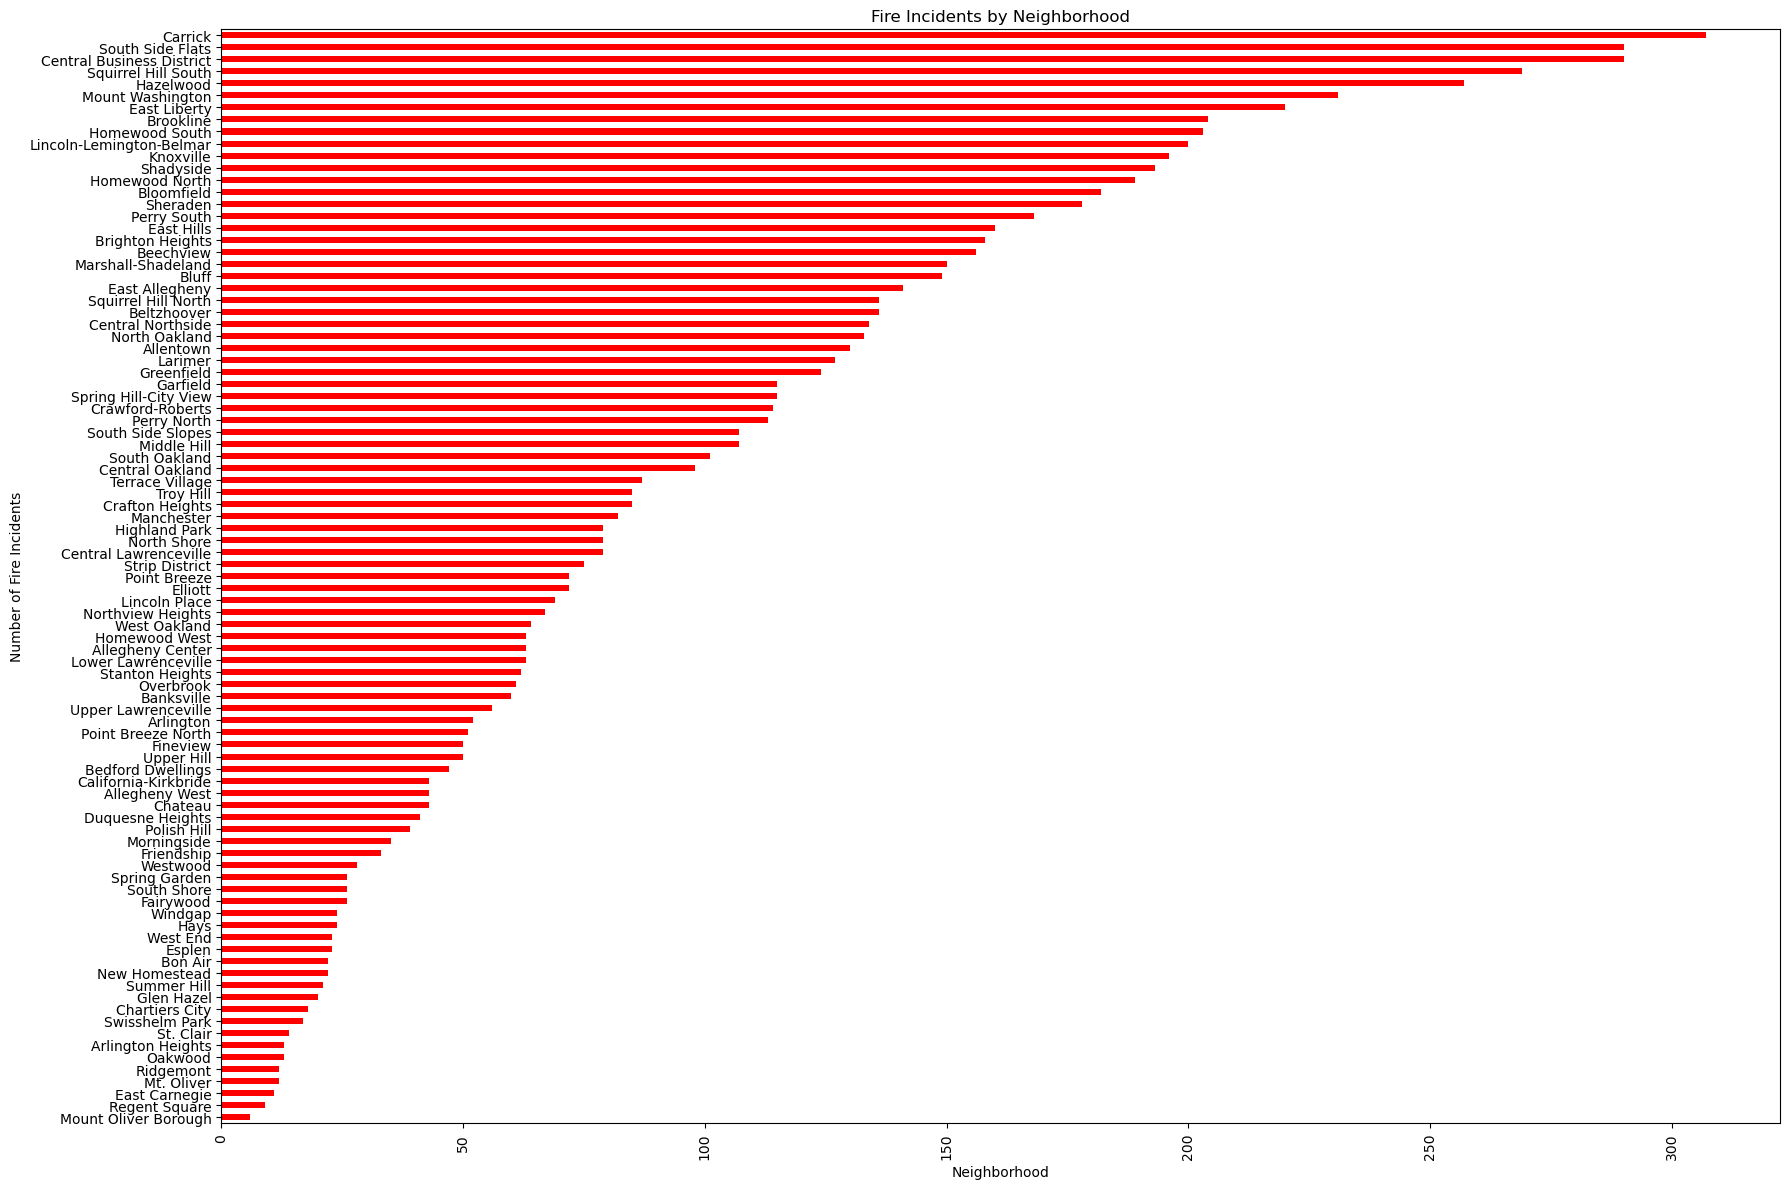

In [282]:
import matplotlib.pyplot as plt
count = data['neighborhood'].value_counts()
count_sorted = count.sort_values(ascending=True)
plt.figure(figsize=(18, 12))
count_sorted.plot(kind='barh', color='red')
plt.title('Fire Incidents by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Fire Incidents')
plt.xticks(rotation=90)  
plt.tight_layout() 
plt.show()

## Graph

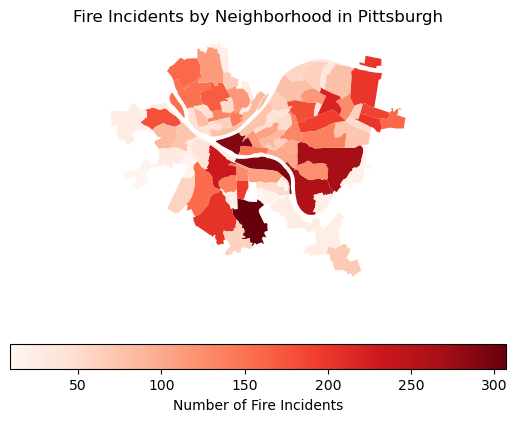

In [284]:
import geopandas as gpd
import matplotlib.pyplot as plt
neighborhoods = gpd.read_file("Neighborhoods_.shp")
weights = count.reset_index()
weights.columns = ['Neighborhood', 'fire_incidents']
map_data = neighborhoods.merge(weights, how='left', left_on='hood', right_on='Neighborhood')
map_data.plot(column='fire_incidents', cmap='Reds', legend=True,
legend_kwds={'label': "Number of Fire Incidents",'orientation': "horizontal"})
plt.title("Fire Incidents by Neighborhood in Pittsburgh")
plt.axis('off')
plt.show()

Clearly, certain neighborhoods have much more vulnerability to fires, while others are far less prone. Considering this is a very historic city, vulnerability to fires is definitely a concern, and so neighborhoods like Mt. Oliver Borough definitely are advantageous in this sense.

# Factor 2: Cleanliness 🧼

To take into factor cleanliness, we looked into the presence of illegal dump sites- that is, places where trash had been illegally stored. To narrow it down even more, we looked into how many tons of trash were estimated to be illegally dumped in each neighborhood.

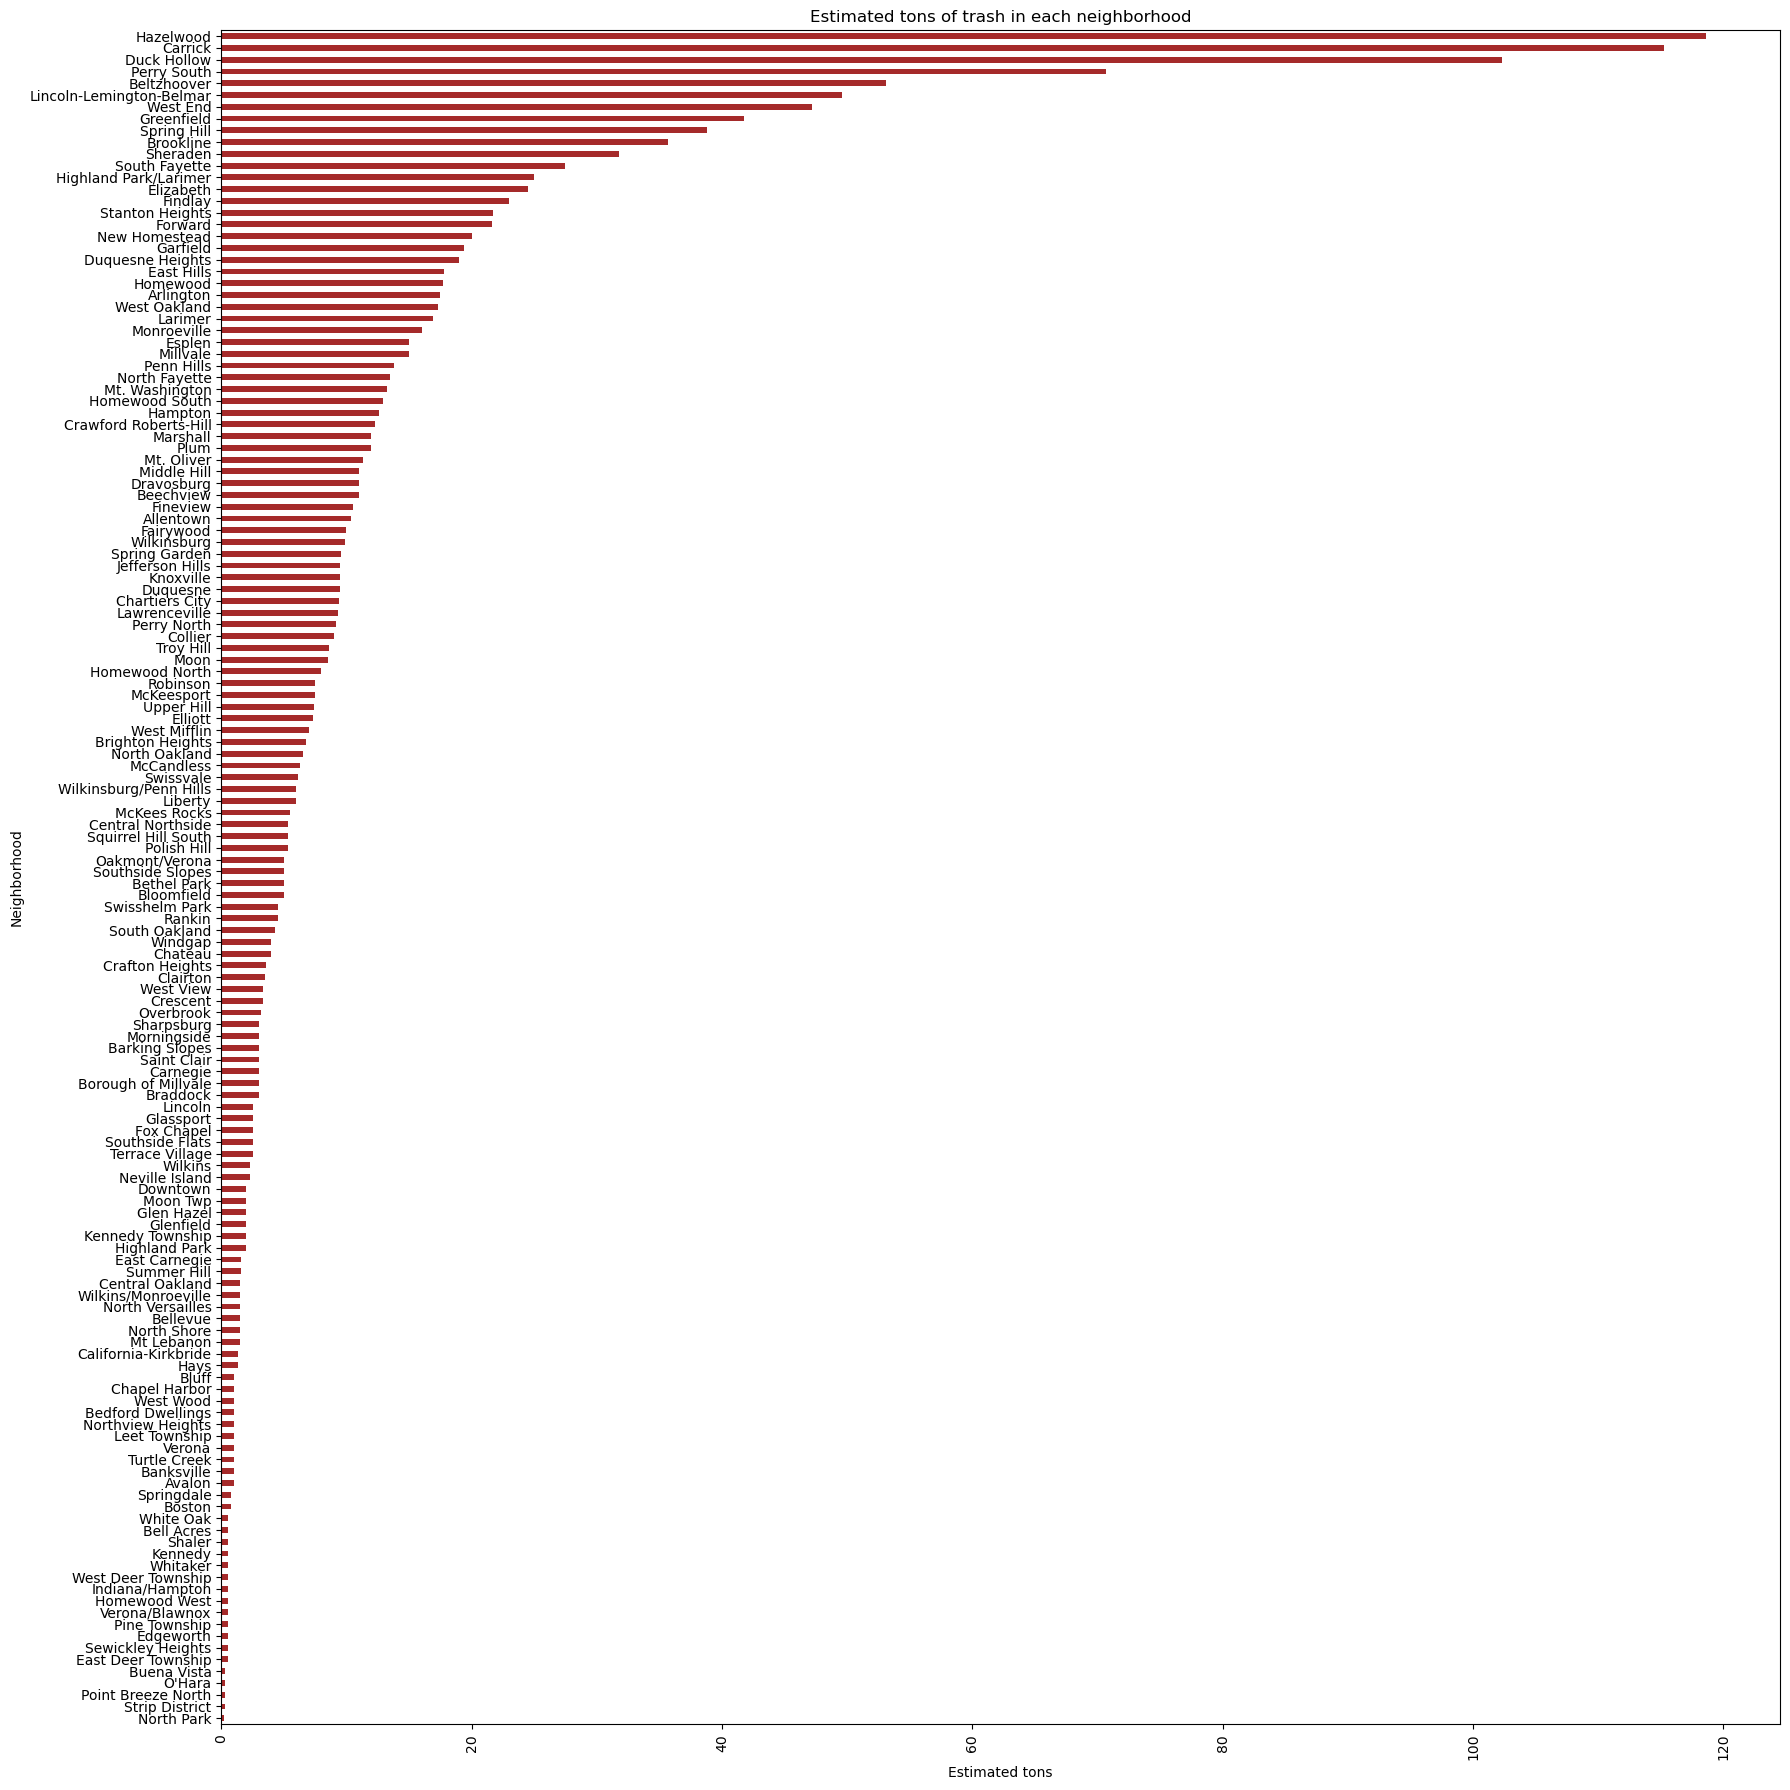

In [286]:
dumps['estimated_tons'] = pd.to_numeric(dumps['estimated_tons'], errors='coerce')
query_mask = dumps['estimated_tons'] > 0
illegal_dumps = dumps[query_mask]

weights = illegal_dumps.groupby('Neighborhood')['estimated_tons'].sum()
weights = weights.sort_values(ascending=True)
plt.figure(figsize=(18,18))
weights.plot(kind='barh', color='brown')
plt.title("Estimated tons of trash in each neighborhood")
plt.xlabel('Estimated tons')
plt.ylabel('Neighborhood')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Graph

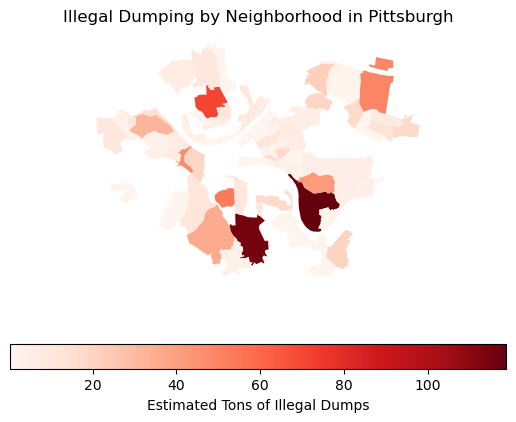

In [288]:
neighborhoods = gpd.read_file("Neighborhoods_.shp")

dumps_map = neighborhoods.merge(weights, how='left', left_on='hood', right_on='Neighborhood')

dumps_map.plot(column='estimated_tons', cmap='Reds', legend=True, 
         legend_kwds={'label': "Estimated Tons of Illegal Dumps",
                      'orientation': "horizontal"})
plt.title("Illegal Dumping by Neighborhood in Pittsburgh")
plt.axis('off')
plt.show()

After analyzing this data, it is clear that there are some neighborhoods which clearly experience far more illegal dumping than others. One might be inspired to move to neighborhoods like East Liberty, and persuaded against neighborhoods experiencing high amounts of illegal dumping, like Hazelwood.

# Factor 3: Crime 🚔

To take into factor crime, we looked into Pittsburgh Police arrest data, and specifically violent crimes, which would obviously disenchant anyone with a neighborhood.

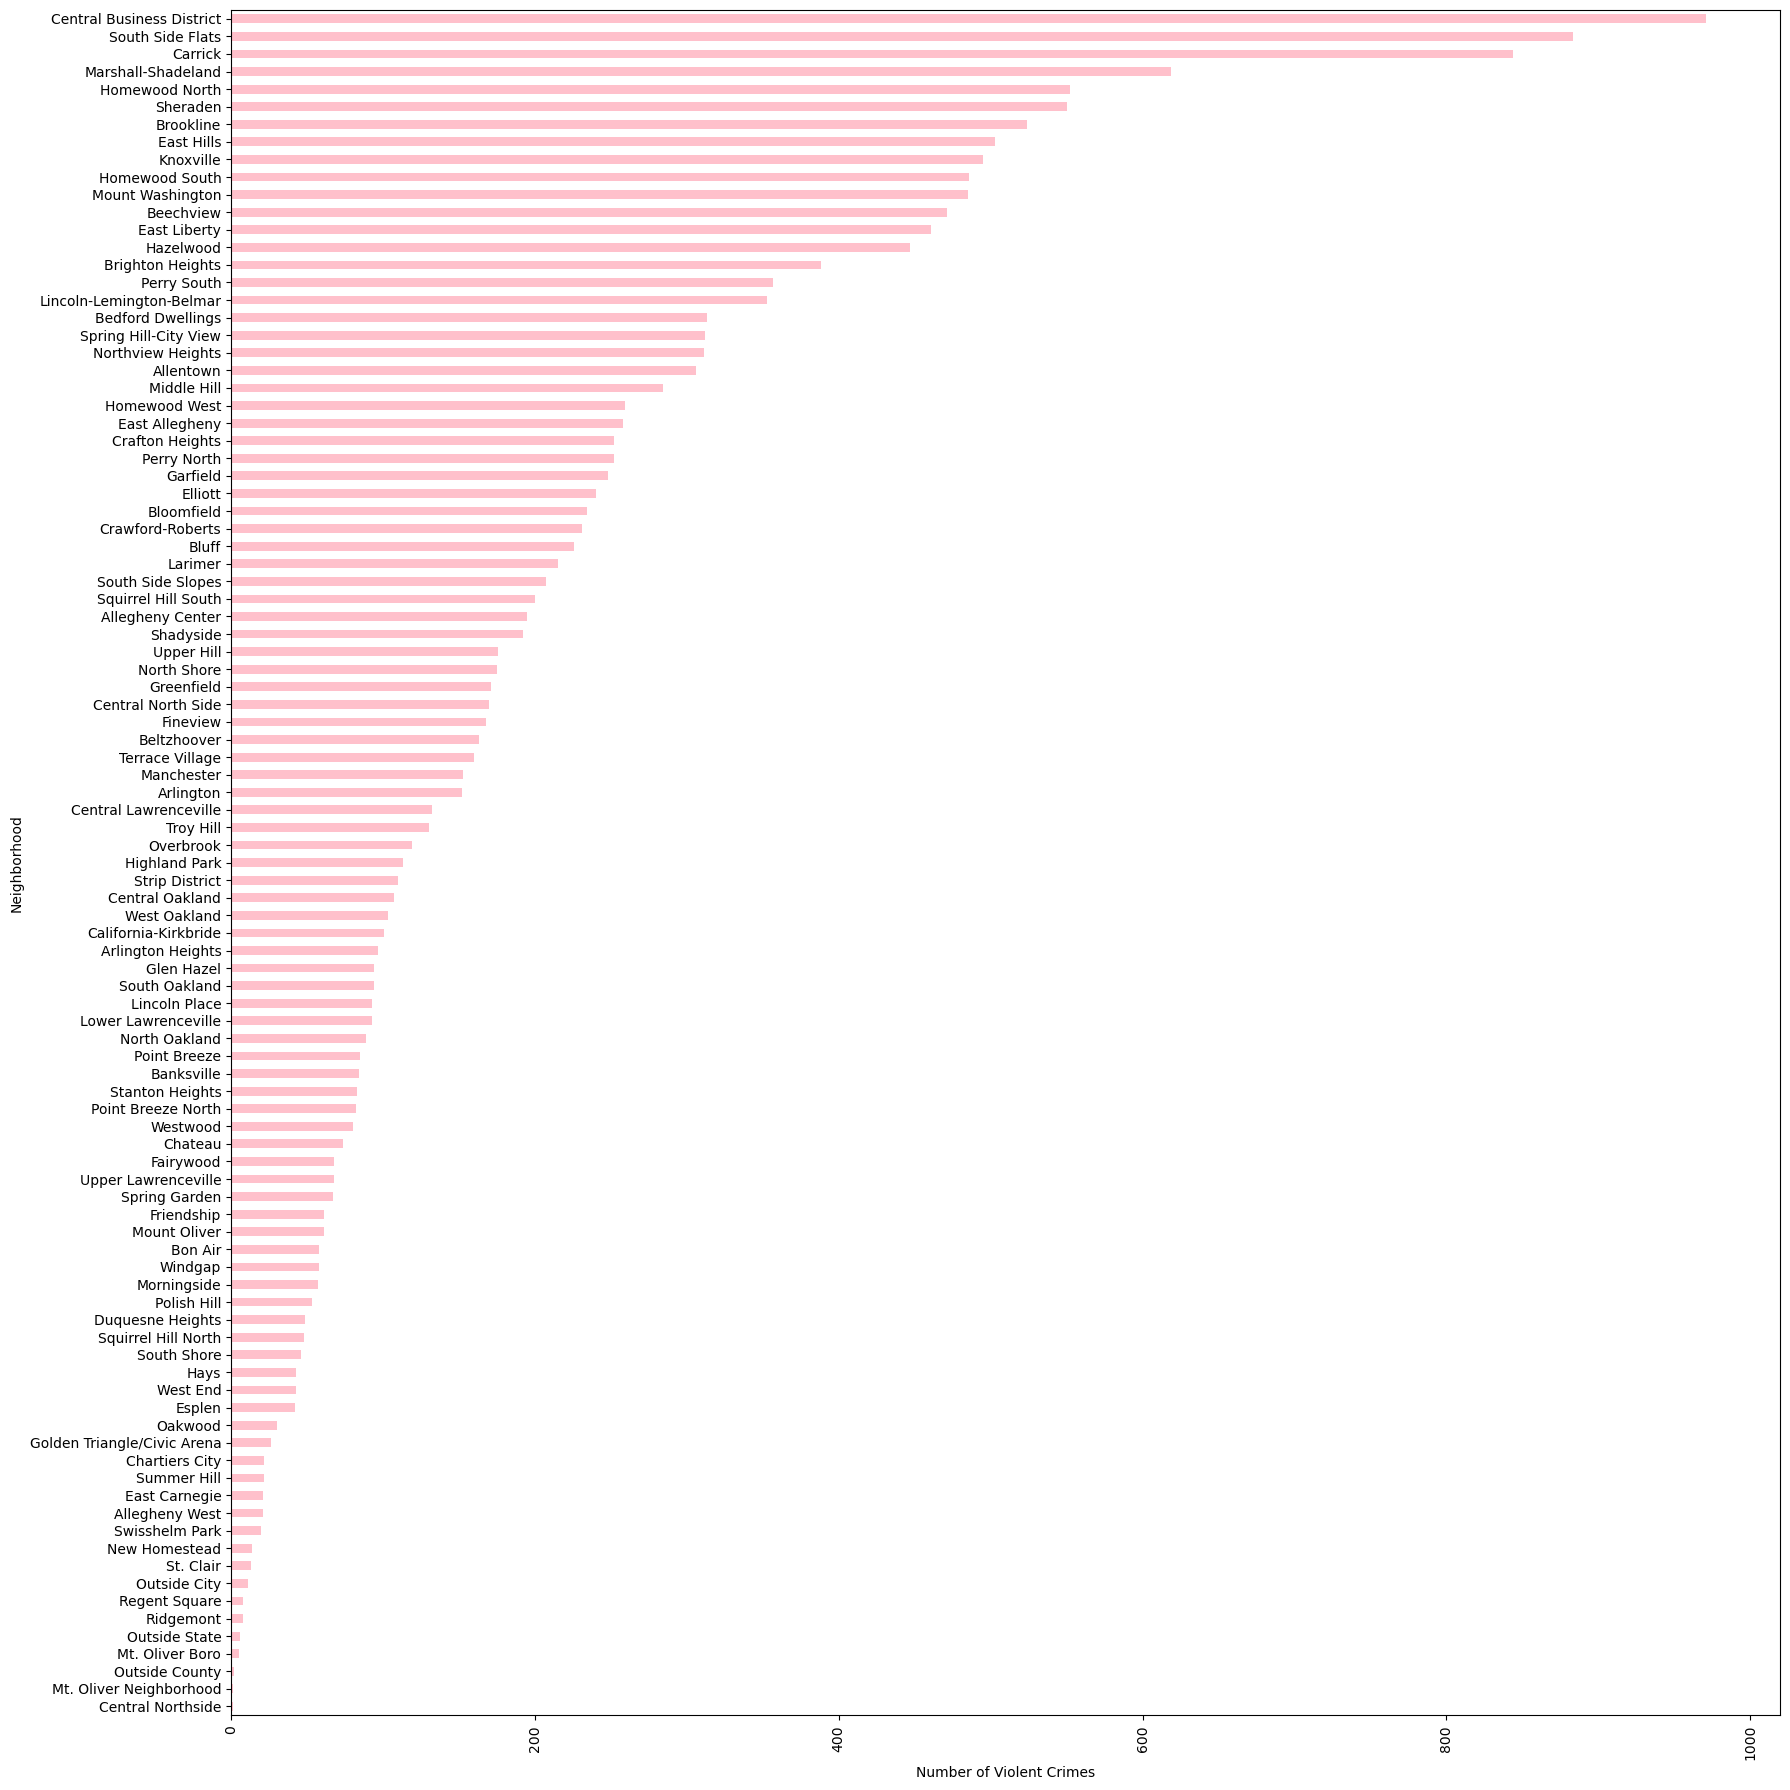

In [308]:
# List of violent crime keywords
violentKeywords = ['assault', 'battery', 'murder', 'aggravated', 'manslaughter', 'rape', 'robbery']

# Ensure OFFENSES are strings
# check if any keyword is present in each offense
arrests['Violence'] = arrests['OFFENSES'].apply(
    lambda x: any(keyword.lower() in str(x).lower() for keyword in violentKeywords) if isinstance(x, str) else False
)

# group by neighborhood and count violent crimes
violent_crimes_by_neighborhood = (
    arrests[arrests['Violence']]  # Filter only violent crimes
    .groupby('INCIDENTNEIGHBORHOOD')  # Group by neighborhood
    .size()  # Count the number of violent crimes per neighborhood
)

violent_crimes_by_neighborhood = violent_crimes_by_neighborhood.sort_values(ascending=True)

# Display the sorted neighborhoods
plt.figure(figsize=(18,18))
violent_crimes_by_neighborhood.plot(kind='barh', color='pink')
plt.xlabel('Number of Violent Crimes')
plt.ylabel('Neighborhood')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

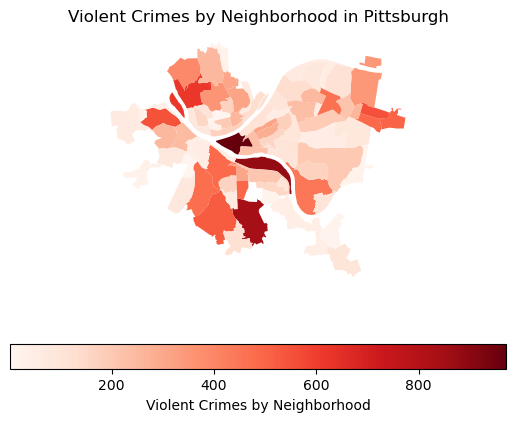

In [310]:
# map out all neighborhoods
neighborhoods = gpd.read_file("Neighborhoods_.shp")

# Rename the column in violent_crimes_by_neighborhood to match 'hood' in neighborhoods
violent_crimes = violent_crimes_by_neighborhood.reset_index()
violent_crimes.columns = ['Neighborhood', 'ViolentCrimeCount']

# Merge the GeoDataFrame with the violent crimes DataFrame
arrests_map = neighborhoods.merge(violent_crimes, how='left', left_on='hood', right_on='Neighborhood')

# Plot the results
arrests_map.plot(column='ViolentCrimeCount', cmap='Reds', legend=True, 
                 legend_kwds={'label': "Violent Crimes by Neighborhood", 
                              'orientation': "horizontal"})
plt.title("Violent Crimes by Neighborhood in Pittsburgh")
plt.axis('off')
plt.show()

We can see that the most populous neighborhoods have the highest quantity of crimes, which makes sense. But these places are the worst to live because the wellbeings of the population is lower due to the large quantity of crimes. The data shows that the smaller quieter places are the best neighborhoods to live in.

## Conclusion

Now, to determine the best neighborhood, we have to take into factor all three of these metrics. We can do this by standardizing each of these metrics to be on a scale of 0 (best) to 1 (worst). Then, we can merge the sum of each into the geopandas neighborhoods map, thereby creating a data frame with the total desirability of each neighborhood.

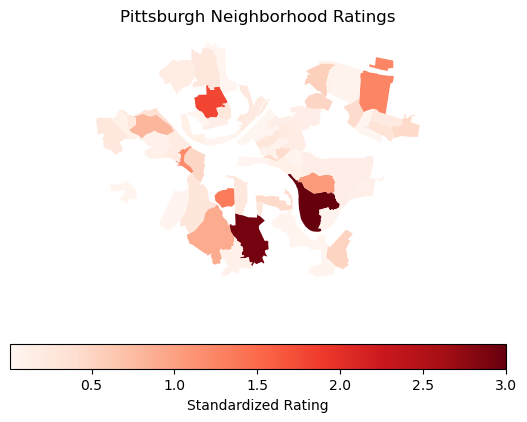

In [312]:
# make a dataframe where rows are each neighborhood and columns are the metric
#make them into gpd
neighborhoods = gpd.read_file("Neighborhoods_.shp")

weights = weights / weights.max()

violent_crimes_by_neighborhood = violent_crimes_by_neighborhood / violent_crimes_by_neighborhood.max()

count = count / count.max()

standard_weight = weights.reset_index()
standard_weight.columns = ['Neighborhood', 'Weight_Rating']

standard_crime = weights.reset_index()
standard_crime.columns = ['Neighborhood', 'Crime_Rating']

standard_fire = weights.reset_index()
standard_fire.columns = ['Neighborhood', 'Fire_Rating']



combined_data = neighborhoods.merge(standard_weight, how='inner', left_on='hood', right_on='Neighborhood')

combined_data = combined_data.merge(standard_crime, how='inner', left_on='hood', right_on='Neighborhood')
combined_data = combined_data.merge(standard_fire, how='inner', left_on='hood', right_on='Neighborhood')

combined_data['Rating'] = combined_data[['Weight_Rating', 'Crime_Rating', 'Fire_Rating']].sum(axis=1)

combined_data.plot(column='Rating', cmap='Reds', legend=True, 
         legend_kwds={'label': "Standardized Rating",
                      'orientation': "horizontal"})
plt.title("Pittsburgh Neighborhood Ratings")
plt.axis('off')
plt.show()

Now, we can look at this map as a graph to see exactly which neighborhood has the best rating (closest to 0)

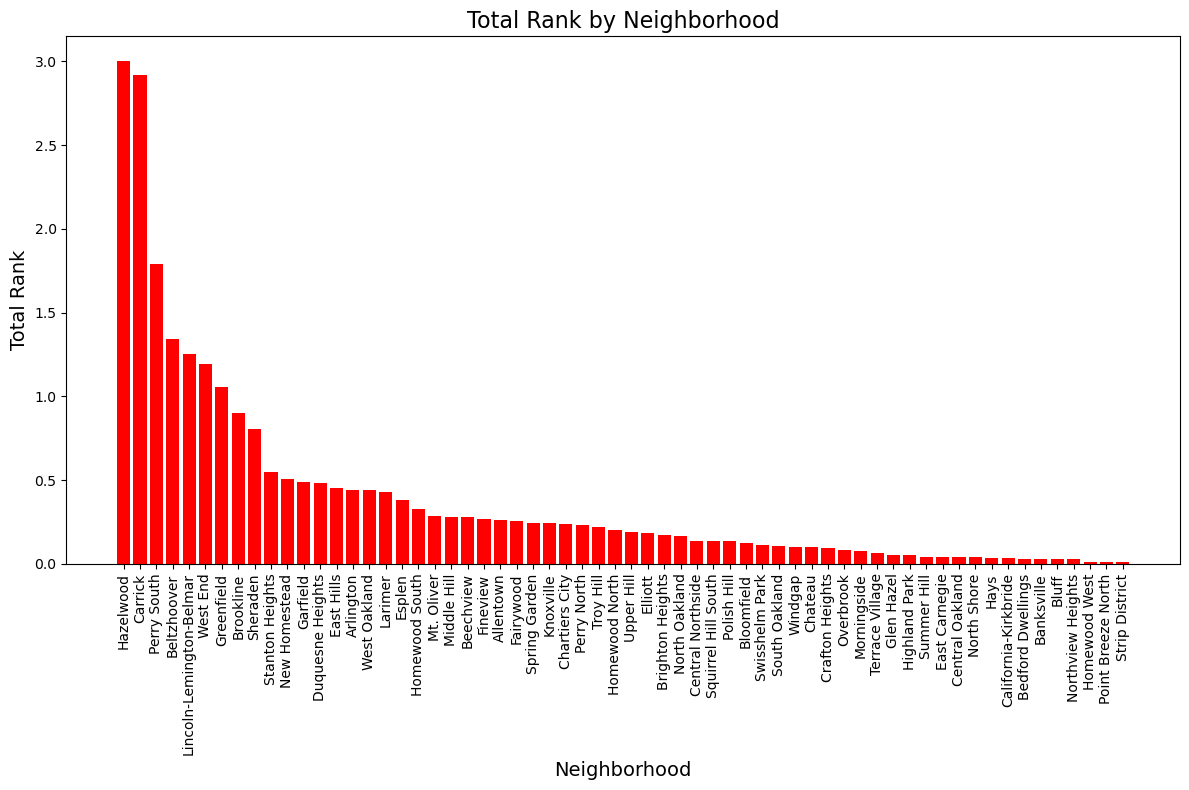

In [314]:
combined_data = combined_data.sort_values(by='Rating', ascending=False)
plt.figure(figsize=(12, 8))
plt.bar(combined_data['hood'], combined_data['Rating'], color='red')
plt.title('Total Rank by Neighborhood', fontsize=16)
plt.xlabel('Neighborhood', fontsize=14)
plt.ylabel('Total Rank', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Conclusion

From this, we can determine that the Strip District is the best neighborhood in Pittsburgh!

Ryan - I agree that the Strip District is the best neighborhood in Pittsburgh. Each factor (crime, cleanliness, and fires) all matter the same to me, so they should have the same weights in the cumulative rating. While the strip district was not the lowest in violent crimes it is a popular area to live, so it is natural there would be more crime. From our data it had the best overall rating and I agree with that. I would live there!

When we weigh each of these three factors the same, we can find that the strip district had the optimal weighted value. Obviously, everybody has different preferences, and so it is important to consider how these weights of each factor would change the results. If someone cared more about crime than cleanliness, this would definitely shift the results. Conversely, someone who had a bad experience with a housefire before would definitely care more about fires. However, our group each cared about one of these factors, and so the weights were even.